# Stroke prediction using MLlib

### Importing Packages

In [150]:
from pyspark.sql import SparkSession
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None

In [140]:
# To increase size of plots
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 5]

### Reading dataset

In [103]:
data = pd.read_csv("gs://cc-project-bucket-spark/healthcare-dataset-stroke-data.csv")
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Cleaning dataset

In [104]:
data = data.drop(columns = ["id"])

# gender
data.gender[data.gender == "Male"] = 0
data.gender[data.gender == "Female"] = 1
data.gender[data.gender == "Other"] = 2

# ever_married
data.ever_married[data.ever_married == "Yes"] = 1
data.ever_married[data.ever_married == "No"] = 0

# work_type
data.work_type[data.work_type == "Private"] = 0
data.work_type[data.work_type == "Self-employed"] = 1
data.work_type[data.work_type == "children"] = 2
data.work_type[data.work_type == "Govt_job"] = 3
data.work_type[data.work_type == "Never_worked"] = 4

# Residence_type
data.Residence_type[data.Residence_type == "Urban"] = 0
data.Residence_type[data.Residence_type == "Rural"] = 1

# smoking_status
data.smoking_status[data.smoking_status == "never smoked"] = 0
data.smoking_status[data.smoking_status == "Unknown"] = 1
data.smoking_status[data.smoking_status == "formerly smoked"] = 2
data.smoking_status[data.smoking_status == "smokes"] = 3

# Dropping NaN values
print(f"Before NaN Drop: ROW:{data.shape[0]}, COL:{data.shape[1]}")
data = data.dropna()
print(f"After NaN Drop: ROW:{data.shape[0]}, COL:{data.shape[1]}")

Before NaN Drop: ROW:5110, COL:11
After NaN Drop: ROW:4909, COL:11


In [105]:
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,0,228.69,36.6,2,1
2,0,80.0,0,1,1,0,1,105.92,32.5,0,1
3,1,49.0,0,0,1,0,0,171.23,34.4,3,1
4,1,79.0,1,0,1,1,1,174.12,24.0,0,1
5,0,81.0,0,0,1,0,0,186.21,29.0,2,1


### Shuffling dataset

In [109]:
data = data.sample(frac = 1).reset_index(drop = True)
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,48.0,0.0,0.0,1.0,0.0,0.0,57.43,53.5,2.0,0.0
1,0.0,67.0,0.0,0.0,1.0,0.0,1.0,208.78,26.7,1.0,0.0
2,1.0,78.0,0.0,1.0,1.0,0.0,0.0,107.18,28.2,0.0,0.0
3,1.0,26.0,0.0,0.0,0.0,0.0,1.0,85.27,24.6,0.0,0.0
4,0.0,78.0,1.0,1.0,1.0,1.0,1.0,106.41,27.3,0.0,0.0


### Visualizing data

Text(0.5, 1.0, 'Stroke counts')

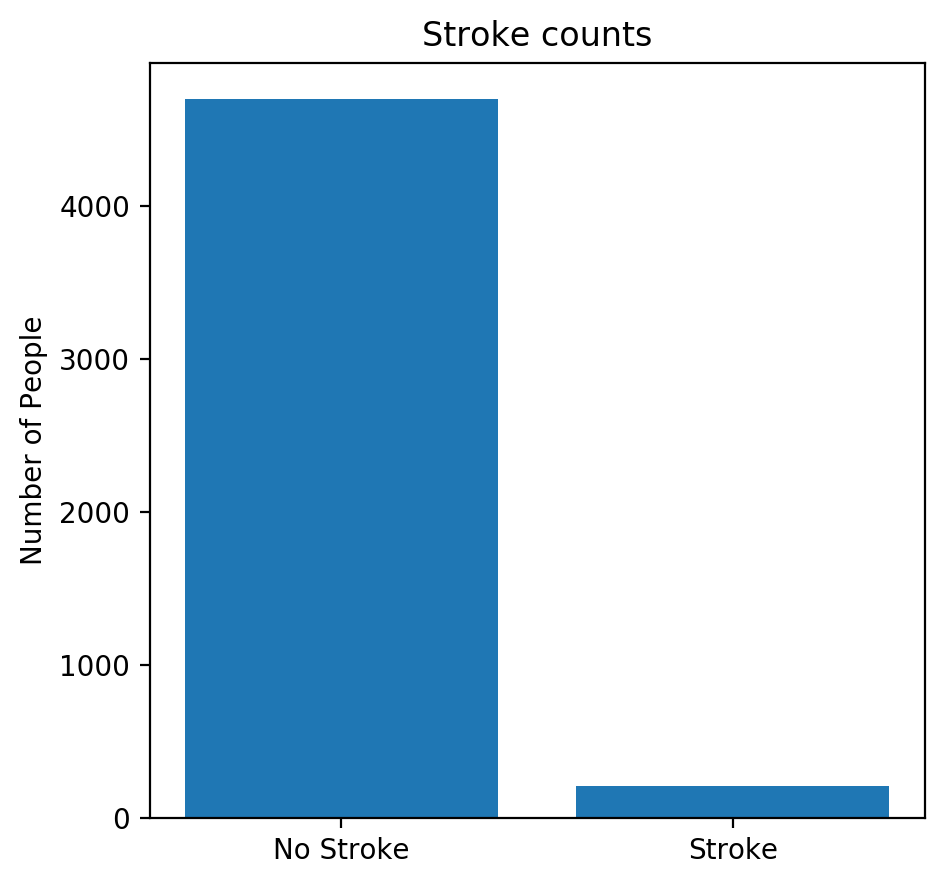

In [142]:
plt.bar(x = ["No Stroke", "Stroke"], height = [data["stroke"].value_counts()[0], data["stroke"].value_counts()[1]])
plt.ylabel("Number of People")
plt.title("Stroke counts")

### Predicting stroke using Logistic Regression

In [125]:
def parse_point(line: list) -> LabeledPoint:
    label = 1 if line[10] == 1 else 0
    return LabeledPoint(line[10], line[0: 10])

In [129]:
data_spark = spark.createDataFrame(data).rdd.map(list)
data_spark = data_spark.map(parse_point)

# Build the model (train the model with parsedDatas)
model = LogisticRegressionWithLBFGS.train(data_spark)

label_pred = data_spark.map(lambda p: (p.label, model.predict(p.features)))
accuracy = label_pred.filter(lambda v: v[0] != v[1]).count() / float(data_spark.count())
print(f"Testing Accuracy: {accuracy}")

Testing Accuracy: 0.044000814829904256


**ROC Curve**

In [145]:
actual_y = label_pred.map(lambda x: x[0]).collect()
predicted_y = label_pred.map(lambda x: x[1]).collect()

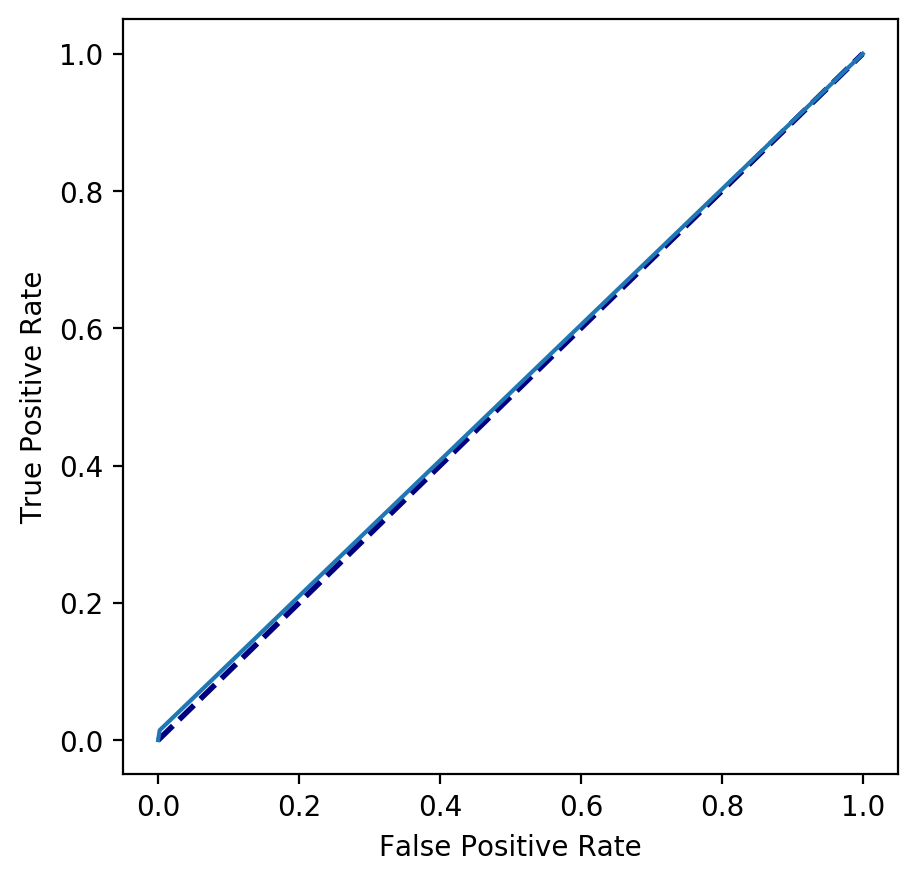

In [159]:
fpr, tpr, _ = roc_curve(actual_y, predicted_y)

# create ROC curve
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle="--")
plt.plot(fpr, tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

### Predicting stroke using Random Forest